# Optimize Physical Descriptors

## P1

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 587.95it/s]


Optimized K0: 4.307614326477051
Optimized n: -5.044186592102051
Optimized m: 4.15341854095459
Optimized a1: 3.1235668659210205
Optimized a2: -0.7120651006698608
Optimized a3: 0.31090518832206726
Optimized a4: 0.5990092754364014
PCC: 0.9160569698923767


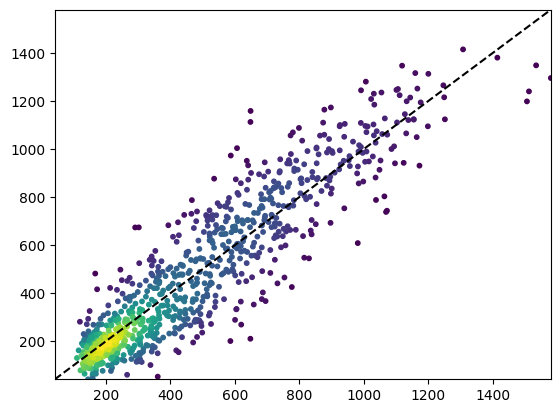

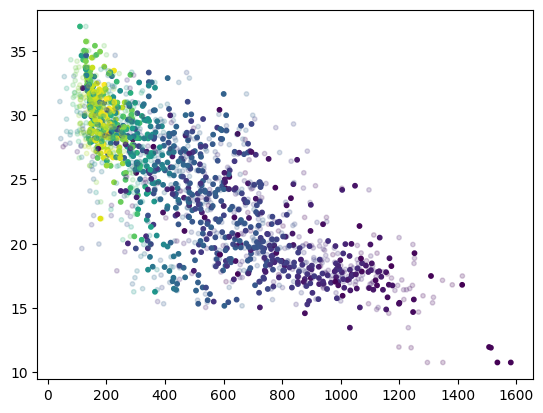

In [11]:
import os
import shutil
import argparse
import numpy as np
import pandas as pd

from numpy import sum as arraysum

import torch
from scipy.optimize import minimize, basinhopping
import torch.optim as optim
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import gaussian_kde, pearsonr
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.font_manager import FontProperties
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import matplotlib.patches as mpatch
from matplotlib.patches import FancyBboxPatch
import matplotlib.transforms as mtransforms

from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

jobPath = "C:/Users/Emily/ML-Adsorption/CGCNN/"

isotherm_type = pd.read_excel(f"{jobPath}isotherm_type4.xlsx").iloc[:, 1]
qmof_indices = torch.load(f"{jobPath}indices.pth")["indices"]

texturalProp_data = pd.read_excel(f"{jobPath}texturalProperties_vol.xlsx")
texturalFeat = torch.tensor(texturalProp_data.iloc[:, 1:].values, dtype=torch.float32)[qmof_indices]

R, T = 0.08314, 298
n = 10

As = texturalFeat[:, 0]/1000       # gravimetric surface area [m^2/g] => [A^2/g]
phi = texturalFeat[:, 1]           # void fraction [-]
PLD = texturalFeat[:, 2]           # pore limiting diameter [A]
LCD = texturalFeat[:, 3]           # largest cavity diameter [A]
rho = texturalFeat[:, 4]           # density [g/cm^3] => [g/A^3]
V = texturalFeat[:, 5]/1000        # volume [A^3]

y_pred_q, y_data_q, count, nums = [], [], 0, []
while count < 19:
    resultName = f"results_{count}.pth"
    if ".pth" in resultName and resultName in os.listdir(f"{jobPath}results/"):
        test = torch.load(f"{jobPath}results/results_{count}.pth")["y_pred_isotherm"]
        y_pred_q += [torch.load(f"{jobPath}results/results_{count}.pth")["y_pred_isotherm"]]
        y_data_q += [torch.load(f"{jobPath}results/results_{count}.pth")["y_data_isotherm"]]
        nums += [count]
    count += 1
y_pred_q = torch.cat(y_pred_q, dim=-1)[:, n]
y_data_q = torch.cat(y_data_q, dim=-1)[:, n]

y_pred_H_tot = torch.load(f"{jobPath}results_H_3_19.pth")["y_pred_isotherm"][:, np.array(nums)-3][:, n]
y_data_H_tot = torch.load(f"{jobPath}results_H_3_19.pth")["y_data_isotherm"][:, np.array(nums)-3][:, n]

P = torch.tensor([5e4,1e5,3e5,4e5,5e5,7e5,1e6,1.5e6,2e6,2.5e6,3e6,3.5e6,4e6,4.5e6,5e6])*0.0000001
P = P.repeat(y_data_H_tot.shape[0], 1)[:, n]

def predict_y(As, rho, V, PLD, LCD, K0, y_pred_H, P, n, phi, m, a1, a2, a3, a4):  
    term1 = As**a1 * rho**a2 * V**a3 * (PLD / LCD)**a4 * K0 * torch.exp(-y_pred_H_tot / (R * T)) * (P) * (1 - phi)
    term2 = (K0 * torch.exp(-y_pred_H_tot / (R * T)) * (PLD / LCD)**a4 * (P))
    return ((term1 / 1+(term2**m))**(1/m)) * (P**n)

def loss_function(y_pred, y_true):
    return torch.mean((y_pred - y_true) ** 2)

y_true = y_pred_q

K0 = torch.tensor(1, dtype=torch.float32, requires_grad=True)  # Initial K0 value
n = torch.tensor(0.5, dtype=torch.float32, requires_grad=True)  # Initial n value
m = torch.tensor(1, dtype=torch.float32, requires_grad=True)  # Initial n value
scale = torch.tensor(1, dtype=torch.float32, requires_grad=True)  # Initial n value
a1 = torch.tensor(1, dtype=torch.float32, requires_grad=True)  # Initial n value
a2 = torch.tensor(1, dtype=torch.float32, requires_grad=True)  # Initial n value
a3 = torch.tensor(1, dtype=torch.float32, requires_grad=True)  # Initial n value
a4 = torch.tensor(1, dtype=torch.float32, requires_grad=True)  # Initial n value
c1 = torch.tensor(1, dtype=torch.float32, requires_grad=True)  # Initial n value
d1 = torch.tensor(1, dtype=torch.float32, requires_grad=True)  # Initial n value
d2 = torch.tensor(1, dtype=torch.float32, requires_grad=True)  # Initial n value

optimizer = optim.Adam([K0, n, m, a1, a2, a3, a4], lr=0.01)

num_epochs = 5000
for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()  
    y_pred = predict_y(As, rho, V, PLD, LCD, K0, y_pred_H_tot, P, n, phi, m, a1, a2, a3, a4)

    loss = loss_function(y_pred, y_true)

    loss.backward(retain_graph=True)
    optimizer.step()

# After training, the optimized values of K0 and n will be:
print(f'Optimized K0: {K0.item()}')
print(f'Optimized n: {n.item()}')
print(f'Optimized m: {m.item()}')
print(f'Optimized a1: {a1.item()}')
print(f'Optimized a2: {a2.item()}')
print(f'Optimized a3: {a3.item()}')
print(f'Optimized a4: {a4.item()}')

y_pred_q, a = y_pred_q.detach(), predict_y(As, rho, V, PLD, LCD, K0, y_pred_H_tot, P, n, phi, m, a1, a2, a3, a4).detach()

b = (y_pred_q).detach()
c = y_pred_H_tot.detach()

min_val = torch.min(torch.min(torch.tensor(a)), torch.min(torch.tensor(b)))
max_val = torch.max(torch.max(torch.tensor(a)), torch.max(torch.tensor(b)))

xy = np.column_stack([a.flatten().detach().numpy(), b.flatten().detach().numpy()])
df = pd.DataFrame(xy, columns=['Predicted', 'Actual'])

kde = gaussian_kde(xy.T)
z = kde(xy.T)

plt.figure()
plt.scatter(a, b, c=z, s=10)
plt.plot(np.linspace(min_val, max_val), np.linspace(min_val, max_val), linestyle="dashed", color="black")
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

plt.figure()
plt.scatter(a, c, c=z, s=10)
plt.scatter(b, c, c=z, alpha=0.2, s=10)

print(f"PCC: {pearsonr(a, b)[0]}")

## P2

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 601.86it/s]


Optimized K0: 13.486077308654785
Optimized n: -3.1947402954101562
Optimized m: 2.705782413482666
Optimized a1: 0.8705786466598511
Optimized a2: 0.12318526953458786
Optimized a3: -0.10145504772663116
Optimized a4: -0.1607789397239685
Optimized a5: 0.17518913745880127
Optimized b1: 10.317770004272461
Optimized b2: 0.04685236141085625
PCC: [0.92227053]


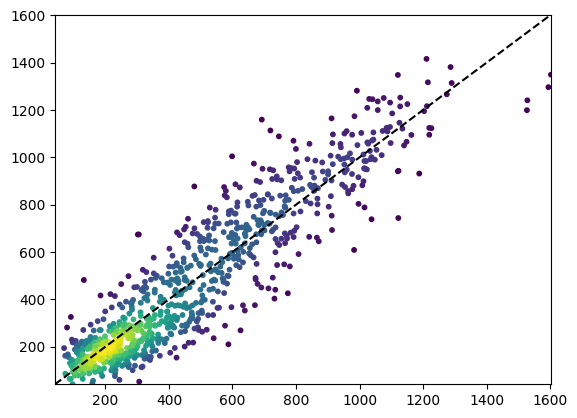

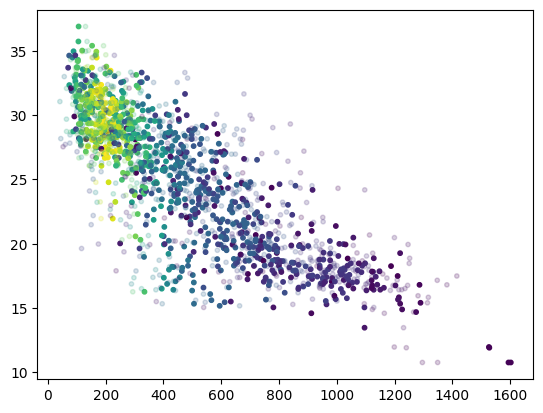

In [8]:
import os
import shutil
import argparse
import numpy as np
import pandas as pd

from numpy import sum as arraysum

import torch
from scipy.optimize import minimize, basinhopping
import torch.optim as optim
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import gaussian_kde, pearsonr
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.font_manager import FontProperties
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import matplotlib.patches as mpatch
from matplotlib.patches import FancyBboxPatch
import matplotlib.transforms as mtransforms

from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

def get_lj_params(atomic_number):
    for element in lj_params:
        if element[0] == atomic_number:
            epsilon = element[1]
            sigma = element[2]
            return epsilon, sigma

jobPath = "C:/Users/Emily/ML-Adsorption/CGCNN/"

isotherm_type = pd.read_excel(f"{jobPath}isotherm_type4.xlsx").iloc[:, 1]
qmof_indices = torch.load(f"{jobPath}indices.pth")["indices"]

texturalProp_data = pd.read_excel(f"{jobPath}texturalProperties_vol.xlsx")
texturalFeat = torch.tensor(texturalProp_data.iloc[:, 1:].values, dtype=torch.float32)[qmof_indices]
node = torch.load(f"{jobPath}X_dataset_test.pth")["nodeFeat"]

R, T = 0.08314, 298
n1 = 10
n2 = n1 + 1

As = texturalFeat[:, 0]/1000 #* 1e-20    # gravimetric surface area [m^2/g] => [A^2/g]
phi = texturalFeat[:, 1]           # void fraction [-]
PLD = texturalFeat[:, 2]           # pore limiting diameter [A]
LCD = texturalFeat[:, 3]           # largest cavity diameter [A]
rho = texturalFeat[:, 4] #* 1e-24   # density [g/cm^3] => [g/A^3]
V = texturalFeat[:, 5]/1000             # volume [A^3]

node_indx = [node[i] for i in qmof_indices]

y_pred_q, y_data_q, count, nums = [], [], 0, []
while count < 19:
    resultName = f"results_{count}.pth"
    if ".pth" in resultName and resultName in os.listdir(f"{jobPath}results/"):
        test = torch.load(f"{jobPath}results/results_{count}.pth")["y_pred_isotherm"]
        y_pred_q += [torch.load(f"{jobPath}results/results_{count}.pth")["y_pred_isotherm"]]
        y_data_q += [torch.load(f"{jobPath}results/results_{count}.pth")["y_data_isotherm"]]
        nums += [count]
    count += 1
y_pred_q = torch.cat(y_pred_q, dim=-1)[:, n1:n2]
y_data_q = torch.cat(y_data_q, dim=-1)[:, n1:n2]

y_pred_H_tot = torch.load(f"{jobPath}results_H_3_19.pth")["y_pred_isotherm"][:, np.array(nums)-3][:, n1:n2]
y_data_H_tot = torch.load(f"{jobPath}results_H_3_19.pth")["y_data_isotherm"][:, np.array(nums)-3][:, n1:n2]

P = torch.tensor([5e4,1e5,3e5,4e5,5e5,7e5,1e6,1.5e6,2e6,2.5e6,3e6,3.5e6,4e6,4.5e6,5e6])*0.0000001
P = P.repeat(y_data_H_tot.shape[0], 1)[:, n1:n2]

As = As.unsqueeze(-1).repeat(1, P.shape[1]) 
phi = phi.unsqueeze(-1).repeat(1, P.shape[1]) 
PLD = PLD.unsqueeze(-1).repeat(1, P.shape[1]) 
LCD = LCD.unsqueeze(-1).repeat(1, P.shape[1]) 
rho = rho.unsqueeze(-1).repeat(1, P.shape[1]) 
V = V.unsqueeze(-1).repeat(1, P.shape[1]) 

d_co2 = 3.3
alpha = 26.3
Q = 4.3
eps_co2, sigma_co2 = 195, 3.65

lj_params = [
    (1, 36.0, 2.60),   # H
    (2, 165.0, 2.82),   # He
    (3, 140.0, 2.64),   # Li
    (4, 300.0, 2.85),   # Be
    (5, 360.0, 2.89),   # B
    (6, 480.0, 2.94),   # C
    (7, 500.0, 2.91),   # N
    (8, 550.0, 2.95),   # O
    (9, 550.0, 3.00),   # F
    (10, 850.0, 3.05),  # Ne
    (11, 210.0, 2.80),  # Na
    (12, 350.0, 2.85),  # Mg
    (13, 380.0, 3.00),  # Al
    (14, 400.0, 3.05),  # Si
    (15, 410.0, 3.10),  # P
    (16, 420.0, 3.15),  # S
    (17, 420.0, 3.10),  # Cl
    (18, 700.0, 3.15),  # Ar
    (19, 210.0, 2.85),  # K
    (20, 350.0, 3.00),  # Ca
    (21, 380.0, 3.10),  # Sc
    (22, 400.0, 3.15),  # Ti
    (23, 420.0, 3.20),  # V
    (24, 440.0, 3.25),  # Cr
    (25, 460.0, 3.30),  # Mn
    (26, 480.0, 3.35),  # Fe
    (27, 500.0, 3.40),  # Co
    (28, 520.0, 3.45),  # Ni
    (29, 540.0, 3.50),  # Cu
    (30, 560.0, 3.55),  # Zn
    (31, 580.0, 3.60),  # Ga
    (32, 600.0, 3.65),  # Ge
    (33, 620.0, 3.70),  # As
    (34, 640.0, 3.75),  # Se
    (35, 660.0, 3.80),  # Br
    (36, 680.0, 3.85),  # Kr
    (37, 210.0, 2.90),  # Rb
    (38, 350.0, 3.05),  # Sr
    (39, 380.0, 3.10),  # Y
    (40, 400.0, 3.15),  # Zr
    (41, 420.0, 3.20),  # Nb
    (42, 440.0, 3.25),  # Mo
    (43, 460.0, 3.30),  # Tc
    (44, 480.0, 3.35),  # Ru
    (45, 500.0, 3.40),  # Rh
    (46, 520.0, 3.45),  # Pd
    (47, 540.0, 3.50),  # Ag
    (48, 560.0, 3.55),  # Cd
    (49, 580.0, 3.60),  # In
    (50, 600.0, 3.65),  # Sn
    (51, 620.0, 3.70),  # Sb
    (52, 640.0, 3.75),  # I
    (53, 660.0, 3.80),  # Xe
    (54, 680.0, 3.85),  # Cs
    (55, 210.0, 2.95),  # Ba
    (56, 350.0, 3.05),  # La
    (57, 380.0, 3.10),  # Ce
    (58, 400.0, 3.15),  # Pr
    (59, 420.0, 3.20),  # Nd
    (60, 440.0, 3.25),  # Pm
    (61, 460.0, 3.30),  # Sm
    (62, 480.0, 3.35),  # Eu
    (63, 500.0, 3.40),  # Gd
    (64, 520.0, 3.45),  # Tb
    (65, 540.0, 3.50),  # Dy
    (66, 560.0, 3.55),  # Ho
    (67, 580.0, 3.60),  # Er
    (68, 600.0, 3.65),  # Tm
    (69, 620.0, 3.70),  # Yb
    (70, 640.0, 3.75),  # Lu
    (71, 660.0, 3.80),  # Hf
    (72, 680.0, 3.85),  # Ta
    (73, 700.0, 3.90),  # W
    (74, 720.0, 3.95),  # Re
    (75, 740.0, 4.00),  # Os
    (76, 760.0, 4.05),  # Ir
    (77, 780.0, 4.10),  # Pt
    (78, 800.0, 4.15),  # Au
    (79, 820.0, 4.20),  # Hg
    (80, 840.0, 4.25),  # Tl
    (81, 860.0, 4.30),  # Pb
    (82, 880.0, 4.35),  # Bi
    (83, 900.0, 4.40),  # Po
    (84, 920.0, 4.45),  # At
    (85, 940.0, 4.50),  # Rn
    (86, 960.0, 4.55),  # Fr
    (87, 980.0, 4.60),  # Ra
    (88, 1000.0, 4.65), # Ac
    (89, 1020.0, 4.70), # Th
    (90, 1040.0, 4.75), # Pa
    (91, 1060.0, 4.80), # U
    (92, 1080.0, 4.85), # Np
    (93, 1100.0, 4.90), # Pu
    (94, 1120.0, 4.95), # Am
    (95, 1140.0, 5.00), # Cm
    (96, 1160.0, 5.05), # Bk
    (97, 1180.0, 5.10), # Cf
    (98, 1200.0, 5.15), # Es
    (99, 1220.0, 5.20), # Fm
    (100, 1240.0, 5.25) # Md
]

disp_all = []
for i in tqdm(range(len(node_indx))):
    x = node_indx[i]
    disp = 0
    for j in range(len(x[0])):
        eps, sig = get_lj_params(x[0][j])
        eps_mix = (eps_co2*eps)**0.5
        sigma_mix = 0.5*(sigma_co2+sig)
        disp += eps_mix*d_co2/(sigma_mix+d_co2)
    disp_all += [disp * 8.617333262e-5]
disp_all = torch.tensor(disp_all).unsqueeze(-1)

def predict_y(As, rho, V, PLD, LCD, K0, y_pred_H, P, n, phi, m, a1, a2, a3, a4, a5, b1, b2):  
    term0 = K0 * torch.exp((-y_pred_H_tot/(R*T))) * (1 + b1*disp_all**b2) 
    term1 =  As**a1 * rho**a2 * V**a3 * (1-phi)**a4 * (PLD/LCD)**a5 
    term2 = K0 * torch.exp((-y_pred_H_tot/(R*T)))
    return term1*(term0*P/(1+P*term2))**m + P**n 

def loss_function(y_pred, y_true):
    return torch.mean((y_pred - y_true) ** 2)

y_true = y_pred_q

K0 = torch.tensor(1, dtype=torch.float32, requires_grad=True)  # Initial K0 value
n = torch.tensor(0.5, dtype=torch.float32, requires_grad=True)  # Initial n value
m = torch.tensor(1, dtype=torch.float32, requires_grad=True)  # Initial n value
a1 = torch.tensor(1, dtype=torch.float32, requires_grad=True)  # Initial n value
a2 = torch.tensor(1, dtype=torch.float32, requires_grad=True)  # Initial n value
a3 = torch.tensor(1, dtype=torch.float32, requires_grad=True)  # Initial n value
a4 = torch.tensor(1, dtype=torch.float32, requires_grad=True)  # Initial n value
a5 = torch.tensor(1, dtype=torch.float32, requires_grad=True)  # Initial n value
b1 = torch.tensor(1, dtype=torch.float32, requires_grad=True)  # Initial n value
b2 = torch.tensor(1, dtype=torch.float32, requires_grad=True)  # Initial n value


optimizer = optim.Adam([K0, n, m, a1, a2, a3, a4, a5, b1, b2], lr=0.01)

num_epochs = 5000
for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()  
    y_pred = predict_y(As, rho, V, PLD, LCD, K0, y_pred_H_tot, P, n, phi, m, a1, a2, a3, a4, a5, b1, b2)

    loss = loss_function(y_pred, y_true)

    loss.backward(retain_graph=True)
    optimizer.step()

# After training, the optimized values will be:
print(f'Optimized K0: {K0.item()}')
print(f'Optimized n: {n.item()}')
print(f'Optimized m: {m.item()}')
print(f'Optimized a1: {a1.item()}')
print(f'Optimized a2: {a2.item()}')
print(f'Optimized a3: {a3.item()}')
print(f'Optimized a4: {a4.item()}')
print(f'Optimized a5: {a5.item()}')
print(f'Optimized b1: {b1.item()}')
print(f'Optimized b2: {b2.item()}')

y_pred_q, a = y_pred_q.detach(), predict_y(As, rho, V, PLD, LCD, K0, y_pred_H_tot, P, n, phi, m, a1, a2, a3, a4, a5, b1, b2).detach()

b = (y_pred_q).detach()
c = y_pred_H_tot.detach()

min_val = torch.min(torch.min(torch.tensor(a)), torch.min(torch.tensor(b)))
max_val = torch.max(torch.max(torch.tensor(a)), torch.max(torch.tensor(b)))

z = torch.tensor(isotherm_type[qmof_indices].to_numpy()).unsqueeze(-1)

xy = np.column_stack([a.flatten().detach().numpy(), b.flatten().detach().numpy()])
df = pd.DataFrame(xy, columns=['Predicted', 'Actual'])

kde = gaussian_kde(xy.T)
z = kde(xy.T)

plt.figure()
plt.scatter(a, b, c=z, s=10)
plt.plot(np.linspace(min_val, max_val), np.linspace(min_val, max_val), linestyle="dashed", color="black")
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

plt.figure()
plt.scatter(a, c, c=z, s=10)
plt.scatter(b, c, c=z, alpha=0.2, s=10)

print(f"PCC: {pearsonr(a, b)[0]}")
